In [1]:
# import json
import requests
import pandas as pd
import plotly
import plotly.graph_objects as go

# https://stackoverflow.com/questions/13598958/import-modules-from-different-folders
import sys
sys.path.append('C:/Users/Scott/CloudStation/Drive/Jupyter/Coivd19')
import CensusData

from datetime import datetime, timedelta

In [2]:
dfStateData = CensusData.StateData()

https://api.census.gov/data/2019/pep/population?get=POP&for=state:*
Population data API call result: 200 OK
https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*
State name API call result: 200 OK


# Data Sources  
Google: https://www.google.com/covid19/mobility/  
Apple: https://www.apple.com/covid19/mobility

In [3]:
# Downloaded mobility data csv files
appleCSV = 'applemobilitytrends-2020-05-17'
googleCSV = 'Global_Mobility_Report'

csvFolder = 'C:/Users/Scott/CloudStation/Drive/Jupyter/Coivd19/data/'

appleCSV = csvFolder + appleCSV + '.csv'
googleCSV = csvFolder + googleCSV + '.csv'

# Read mobility data
dfAppleRaw = pd.read_csv(appleCSV)
dfGoogleRaw = pd.read_csv(googleCSV)       

C:\Users\Scott\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



## Apple

In [4]:
def apple_mobility_data(dfAppleRaw):

    # Get data for specific state
    appleStateDataRaw = dfAppleRaw[dfAppleRaw['region'] == state].T
    # print(appleStateDataRaw)

    # Data header
    appleTransType = 'apple_' + appleStateDataRaw.iloc[2]
    # print(appleTransType)

    # Create formatted dataframe of state data
    dfAppleState = appleStateDataRaw.iloc[4:]
    dfAppleState.rename(columns = appleTransType, inplace = True)
    dfAppleState.index.names = ['date']
    dfAppleState = dfAppleState.assign(state=state).set_index('state', append = True)

    # print(dfAppleState.index)
    # print(dfAppleState)

    return dfAppleState

## Google

In [5]:
def google_mobility_data(dfGoogleRaw):
    # Filter data to just state level
    googleStateDataRaw = dfGoogleRaw[(dfGoogleRaw['sub_region_1'] == state) & (pd.isnull(dfGoogleRaw['sub_region_2']))]

    # Clean up data headers
    googleHeadersRaw = googleStateDataRaw.columns.values
    # print(googleHeadersRaw)
    trashString = '_percent_change_from_baseline'
    googleHeaders = [x.replace(trashString,'') for x in googleHeadersRaw]
    googleHeaders = [('google_' + x) for x in googleHeaders]
    # print(googleHeaders)

    # Create formatted dataframe of state data
    googleStateData = googleStateDataRaw
    googleStateData.columns = googleHeaders
    googleStateData.rename(columns = {'google_sub_region_1': 'state',
                                     'google_date': 'date'}, inplace = True)
    googleStateData = googleStateData.set_index(['date', 'state'])

    # Remove spurious columns
    dropCols = ['google_country_region_code', 'google_country_region', 'google_sub_region_2']
    googleStateData.drop(dropCols, axis = 1, errors = 'ignore', inplace = True)


    # headers = googleData.columns.values
    # headers = [('google_' + x) for x in headers]
    # googleData.columns = headers


    # print(googleData.head(5))
    # print(googleData.index)

    return googleStateData


## Merge Apple and Google

In [70]:
# Create master mobility dataframe
dfMobility = pd.DataFrame()
for state in dfStateData['State']:
    # Get state mobility data
    dfAppleState = apple_mobility_data(dfAppleRaw)
    googleStateData = google_mobility_data(dfGoogleRaw)        

    # Merge mobility data sources
    dfMobilityState = pd.merge(dfAppleState, googleStateData, how ='outer', right_index=True, left_index=True)
    
    # Add state to master mobility dataframe
    dfMobility = dfMobility.append(dfMobilityState)
    
# Fix index order
dfMobility = dfMobility.reorder_levels([1,0])
dfMobility = dfMobility.sort_index()

# Normalize Apple data to google data
dfMobility['apple_driving'] = dfMobility['apple_driving'] - 100
# Set data to fractional
dfMobility = dfMobility / 100

# Get mean and 7 day mean of mobility measures
dfMobility['mean'] = dfMobility.mean(axis = 1, skipna = True)
dfMobility['mean_rolling_7_day'] = dfMobility['mean'].rolling(window = 7, min_periods = 3, center = True).mean()


(6552, 7)


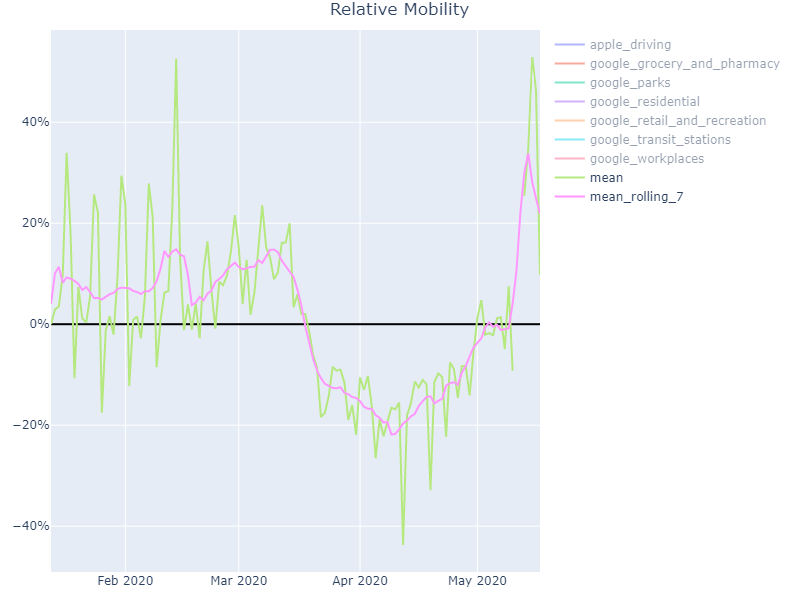

In [80]:
# test = dfMobility
# test = test.reorder_levels([1,0])
# test = test.sort_index()

# print(test.index.values)

# state = 'Alabama'
state = 'New York'
figHeight = 600
figWidth = 800
# print(test.head(5))
# print(test.loc[state])



fig = go.Figure()

dates = test.loc[state].index.values

for column in test:
    data = test.loc[state][column]
    if 'mean' in column:
        visible = True
    else:
        visible = 'legendonly'
        
    fig.add_trace(go.Scatter(x = dates, y = data,
                             name = column,
                             visible = visible))
    
    
fig.update_layout(
    title = {
        'text':'Relative Mobility',
        'x':0.5,
        'xanchor': 'center'},
    height = figHeight,
    width = figWidth,
    hovermode = 'x unified',
    showlegend = True,
    margin = dict(l=20, r=20, t=30, b=20),
    yaxis_tickformat = '1%',
    yaxis_zeroline=True, yaxis_zerolinewidth=2, yaxis_zerolinecolor='black')

# print(dates.head(5))
fig.show()